<h1><center>Lab 2: Classification</center></h1>
<h3><center>A Deeper Analysis of Covid-19 Data</center></h3>
<p><center>DS 7331</center></p>
<p><center>Created by Sadik Aman, Dawn Bowerman, Zachary Harris, Alexandre Jasserme</center></p>

<p><center>Sections of this code was adapted from: 
    <li>https://github.com/jakemdrew/DataMiningNotebooks</li>
    <li> https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html</li>
    <li> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html </li>
    <li> https://machinelearningmastery.com/random-forest-ensemble-in-python/ </li>

## Data Preparation Part 1  - ALEX

> **Define and prepare your class variables. Use proper variable representations
(int, float, one-hot, etc.).
Use pre-processing methods (as needed) for dimensionality
reduction, scaling, etc. 
Remove variables that are not needed/useful for the analysis.**

In [1]:
from __future__ import print_function

#Libraries
import plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pyplot import figure
from sklearn.model_selection import TimeSeriesSplit
import random as rd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError

In [2]:
#Loading in the CSV file and displaying the resulting dataframe
covid_data = pd.read_csv('data/owid-covid-data.csv')
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154105 entries, 0 to 154104
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    154105 non-null  object 
 1   continent                                   144825 non-null  object 
 2   location                                    154105 non-null  object 
 3   date                                        154105 non-null  object 
 4   total_cases                                 151434 non-null  float64
 5   new_cases                                   151379 non-null  float64
 6   new_cases_smoothed                          150228 non-null  float64
 7   total_deaths                                134139 non-null  float64
 8   new_deaths                                  134314 non-null  float64
 9   new_deaths_smoothed                         134182 non-null  float64
 

In [3]:
# Prepare the variables

# Dropping attributes that are highly correlated or have many missing values (based on lab 1 analysis)
covid_df = covid_data.drop(covid_data.columns[[0,4,7,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,
                                                     27,28,29,30,31,32,
                                                     33,34,35,36,37,38,40,41,42,43,44,46,54,57,58,63,64,65,66]], axis=1)

# Removing dates before July 1st, 2021 and after December 31, 2021 to have a more manageable data set (with still more than 30,000 rows)
covid_df = covid_df[covid_df.date >= '2021-07-01']
covid_df = covid_df[covid_df.date <= '2021-12-31']

# Removing Oceania because it has a lot of missing values (based on lab 1 analysis)
covid_df = covid_df[~covid_df.continent.isin(['Oceania'])]

# Removing several countries with a lot of missing values (based on lab 1 analysis)
covid_df = covid_df[~covid_df.location.isin(['Turkmenistan', 'Northern Cyprus', 'Sint Maarten (Dutch part)', 'Jersey', 'Guernsey', 'Laos', 'Macao', 'Timor', 'Vatican', 'Saint Kitts and Nevis', 'Saint Vincent and the Grenadines', 'Saint Pierre and Miquelon', 'St. Helena', 'Cook Island', 'Greenland', 'Gibraltar', 'Anguilla'])]

# Handling missing values: our models cannot be trained on data set with missing data.
# We already removed columns and rows that have many missing data and we will impute the remaining missing data.
# Since we are dealing with data collected over time, we have to account for the temporal autocorrelation. 
# So, instead of using the column mean or median to fill-in the missing data, we chose to interpolate it.
covid_df = covid_df.interpolate()

# Creating a new category variable for stringency index that can be used for categorization
covid_df['stringency_range'] = pd.cut(covid_df.stringency_index,[0,10,20,30,40,50,60,70,80,90,100],10,labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']) # creating a new variable

# Creating a new category variable for new_cases that can be used for categorization
covid_df['new_cases_range'] = pd.qcut(covid_df.new_cases, 3, labels=["low", "medium", "high"])

# Creating a new category variable for new_deaths that can be used for categorization
covid_df['new_deaths_range'] = pd.qcut(covid_df.new_deaths, 3, labels=["low", "medium", "high"])

# Ideas from https://scikit-learn.org/stable/modules/cross_validation.html#timeseries-cv
# Sorting data frame by date column
covid_df['date'] = pd.to_datetime(covid_df['date']) # Converting data columnn to datetime
covid_df = covid_df.sort_values(by='date', ascending=True)

# Performing one hot encoding of the location variable
# TODO: discuss with team: do we really need to do this and is it useful? 
# We end up with a dataset containing more than 200 columns
# If team wants to use it, need to add it to covid_df
categ_features = ['location'];
one_hot_df = pd.concat([pd.get_dummies(covid_df[col],prefix=col) for col in categ_features], axis=1)

# Dropping more attributes that are highly correlated or have many missing values (based on lab 1 analysis) or that will not be used for this analysis (stringency_range and new_deaths_range)
covid_df = covid_df.drop(["new_deaths_smoothed",
                    "new_cases",
                    "new_cases_smoothed",
                    "continent",
                    "location",
                    "stringency_range",
                    "date",
                    "new_people_vaccinated_smoothed",
                    "population_density",
                    "aged_70_older",
                    "new_deaths_range"], axis=1)

In [4]:
# TODO: discuss with team: why we are NOT doing one hot
one_hot_df.head()

,location_Afghanistan,location_Africa,location_Albania,location_Algeria,location_Andorra,location_Angola,location_Antigua and Barbuda,location_Argentina,location_Armenia,location_Aruba,...,location_United States,location_Upper middle income,location_Uruguay,location_Uzbekistan,location_Venezuela,location_Vietnam,location_World,location_Yemen,location_Zambia,location_Zimbabwe
493,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ## Data Preparation Part 2 

> **Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).**

In [5]:
print ('Size of the final dataset showing that is has more than 30,000 rows and 15 columns:', covid_df.shape)

Size of the final dataset showing that is has more than 30,000 rows and 15 columns: (37168, 15)


In [6]:
# Overview of the data set:
covid_df.info() #Dataset being analyzed (MAIN DATASET)
covid_df.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37168 entries, 493 to 154092
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   new_deaths                  37168 non-null  float64 
 1   reproduction_rate           37168 non-null  float64 
 2   new_vaccinations_smoothed   37168 non-null  float64 
 3   stringency_index            37168 non-null  float64 
 4   population                  37168 non-null  float64 
 5   median_age                  37168 non-null  float64 
 6   aged_65_older               37168 non-null  float64 
 7   gdp_per_capita              37168 non-null  float64 
 8   cardiovasc_death_rate       37168 non-null  float64 
 9   diabetes_prevalence         37168 non-null  float64 
 10  handwashing_facilities      37168 non-null  float64 
 11  hospital_beds_per_thousand  37168 non-null  float64 
 12  life_expectancy             37168 non-null  float64 
 13  human_develop

,new_deaths,reproduction_rate,new_vaccinations_smoothed,stringency_index,population,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,new_cases_range
493,91.0,0.98,14115.0,46.30,39835428.0,18.6,2.581,1803.987,597.029,9.59,37.746000,0.500,64.83,0.511,high
24994,0.0,0.35,2773.0,29.63,27224262.0,18.8,3.165,3364.926,244.661,7.20,2.735000,1.300,59.29,0.563,low
122783,0.0,0.88,11516.0,32.41,6871547.0,41.2,17.366,14048.881,439.415,10.08,97.719000,5.609,76.00,0.806,medium
24316,26.0,1.10,132856.0,72.69,16946446.0,25.6,4.412,3645.070,270.892,4.00,66.229000,0.800,69.82,0.594,high
123452,1.0,0.93,116.0,76.85,98910.0,36.2,8.606,26382.287,242.648,10.55,97.294978,3.600,73.40,0.796,medium


The original Covid dataset was obtained from the "Our World in Data" website: https://github.com/owid/covid-19-data/tree/master/public/data 

In "Data Preparation Step 1", we removed several attributes from the dataset and here is a description of the remaining attributes in the final dataset will be used for this analysis:
<p><center>Table 1: Attributes</center></p>

| Variable Name                  | Data Type | Description                                                                                                                                                                                                                                                                                                                                           |
|--------------------------------|-----------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| new_deaths                     | numerical | New deaths attributed to COVID-19                                                                                                                                                                                                                                                                                                                     |
| reproduction_rate              | numerical | Real-time estimate of the effective reproduction rate (R) of COVID-19                                                                                                                                                                                                                                                                                 |
| new_vaccinations_smoothed      | numerical | New COVID-19 vaccination doses administered (7-day smoothed).  For countries that don't report vaccination data on a daily basis,  we assume that vaccination changed equally on a daily basis over any periods in which  no data was reported. This produces a complete series of daily figures, which is  then averaged over a rolling 7-day window |
| stringency_index               | numerical | Government Response Stringency Index: composite measure based on 9 response  indicators including school closures, workplace closures,  and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)                                                                                                                                 |
| population                     | numerical | Population                                                                                                                                                                                                                                                                                                                                            |
| median_age                     | numerical | Median age of the population, UN projection for 2020                                                                                                                                                                                                                                                                                                  |
| aged_65_older                  | numerical | Share of the population that is 65 years and older, most recent year available                                                                                                                                                                                                                                                                        |
| gdp_per_capita                 | numerical | Gross domestic product at purchasing power parity  (constant 2011 international dollars),  most recent year available                                                                                                                                                                                                                                 |
| cardiovasc_death_rate          | numerical | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)                                                                                                                                                                                                                                                           |
| diabetes_prevalence            | numerical | Diabetes prevalence (% of population aged 20 to 79) in 2017                                                                                                                                                                                                                                                                                           |
| handwashing_facilities         | numerical | Share of the population with basic handwashing facilities on premises,  most recent year available                                                                                                                                                                                                                                                    |
| hospital_beds_per_thousand     | numerical | Hospital beds per 1,000 people, most recent year available since 2010                                                                                                                                                                                                                                                                                 |
| life_expectancy                | numerical | Life expectancy at birth in 2019                                                                                                                                                                                                                                                                                                                      |
| human_development_index        | numerical | A composite index measuring average achievement in three basic  dimensions of human development—a long and healthy life,  knowledge and a decent standard of living.                                                                                                                                                                                  |
| new_cases_range                | categorical | This is a new variable that will be used to perform the classification task. It was created from the continuous variable new_deaths_range by dividing it in 3 equal parts with values: "high", "medium" and "low".                                                   
                                                                                                                                        |

#### Task 1: Classification of new_cases_range
Task 1 will consist of the classification of the categorical variable new_cases_range.

#### Task 2: Regression of new_deaths
Task 2 will consist of the regression of the continuous variable new_cases_range.

 ## Modeling and Evaluation 1 - Dawn

> **Choose and explain your evaluation metrics that you will use (i.e., accuracy,precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.**



**NOTE: Need to explain Accuracy for the classification**

> We have selected the Root Mean Squared Error (RMSE) for our evaluation metric.  The RMSE measures the average error produced by the model while predicting the result for a study. The RMSE is the square root of the mean squared error (MSE); the average squared difference between the observed actual results and the results predicted by the model. The MSE = mean((observed - predicted)^2) and the RMSE = sqrt(MSE). A model with a lower RMSE is a better model.  We believe that this metric is appropriate because RMSE is a mathematical equation that equates the error between the predicted and the actual results to determine the correctness of a model.  Since most of our data is numerical it is a likely choice as metrics for binary data will not work here.

 ## Modeling and Evaluation 2 - ALEX

> **Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.**

**INSERT EXPLANATION: Choose our method, explain why we chose it/them, and why appropriate**

In [7]:

rd.seed(123) #Setting the seed to maintain consistency and reproducibility of results
#Create Train Test Split for Regression
iter_num=0
# the indices are the rows used for training and testing in each iteration

cv_object = TimeSeriesSplit( n_splits=10)

reg_target = covid_df.new_deaths

#separate the other attributes from the predicting attribute and adjust dataset for regrssion
#reg_df is equivalent to the covid_df dataset, but with an eliminated categorical feature (new_cases_range)
reg_df = covid_df
reg_df = reg_df.drop(["new_deaths","new_cases_range"], axis=1)

X_reg = np.array(reg_df)
y_reg = np.array(reg_target)

for train_indices, test_indices in cv_object.split(X_reg,y_reg): 
    
    X_train_reg = X_reg[train_indices]
    y_train_reg = y_reg[train_indices]
    
    X_test_reg = X_reg[test_indices]
    y_test_reg = y_reg[test_indices]    
    
# scale attributes by the training set
scl_obj_reg = StandardScaler()
scl_obj_reg.fit(X_train_reg) # find scalings for each column that make this zero mean and unit std

X_train_scaled_reg = scl_obj_reg.transform(X_train_reg) # apply to training
X_test_scaled_reg = scl_obj_reg.transform(X_test_reg) # apply those means and std to the test set (without snooping at the test set values)

In [8]:
#Create Train Test Split for Classification
iter_num=0
# the indices are the rows used for training and testing in each iteration

cv_object = TimeSeriesSplit( n_splits=10)

cat_target = covid_df.new_cases_range

#separate the other attributes from the predicting attribute
#Adjusting categorical dataframe to be used for classification models
#Eliminated our response variable, new_cases_range, and a highly correlated variable, new_deaths

cat_df = covid_df
cat_df = cat_df.drop(["new_cases_range","new_deaths"],axis=1)

X_cat = np.array(cat_df)
y_cat = np.array(cat_target)

for train_indices, test_indices in cv_object.split(X_cat,y_cat): 
    
    X_train_cat = X_cat[train_indices]
    y_train_cat = y_cat[train_indices]
    
    X_test_cat = X_cat[test_indices]
    y_test_cat = y_cat[test_indices]
    
# scale attributes by the training set
scl_obj_cat = StandardScaler()
scl_obj_cat.fit(X_train_cat) # find scalings for each column that make this zero mean and unit std

X_train_scaled_cat = scl_obj_cat.transform(X_train_cat) # apply to training
X_test_scaled_cat = scl_obj_cat.transform(X_test_cat) # apply those means and std to the test set (without snooping at the test set values)

 ## Modeling and Evaluation 3 - Zach

> **Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!**

> We have selected RANSAC Regression, Theil-sen Regression, and Support Vector Machine models, kNN, Random Forest to analyze our data

>For regresion, we are executing these models: Linear Regression, 
>For classification, we are executing these models: kNN, etc.

### Support Vector Machines

#### Creating the Model Using Support Vector Machines

accuracy: 0.6391355831853167
[[796 286  87]
 [195 671 328]
 [ 90 233 692]]
(20836, 13)
(20836,)
[5531 6461 8844]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20836 entries, 493 to 131950
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reproduction_rate           20836 non-null  float64
 1   new_vaccinations_smoothed   20836 non-null  float64
 2   stringency_index            20836 non-null  float64
 3   population                  20836 non-null  float64
 4   median_age                  20836 non-null  float64
 5   aged_65_older               20836 non-null  float64
 6   gdp_per_capita              20836 non-null  float64
 7   cardiovasc_death_rate       20836 non-null  float64
 8   diabetes_prevalence         20836 non-null  float64
 9   handwashing_facilities      20836 non-null  float64
 10  hospital_beds_per_thousand  20836 non-null  float64
 11  life_expectancy             2

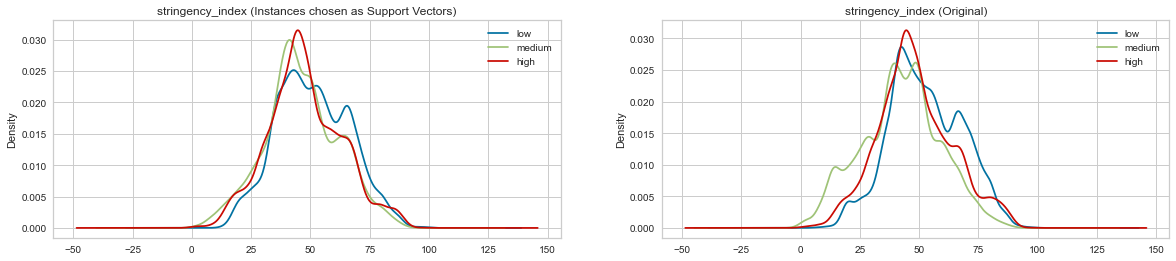

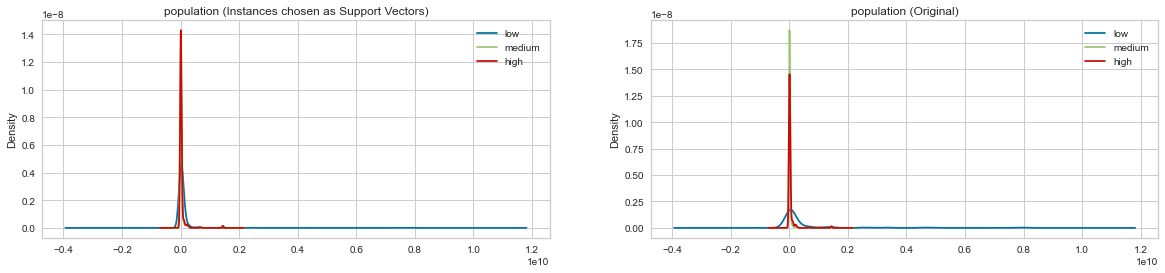

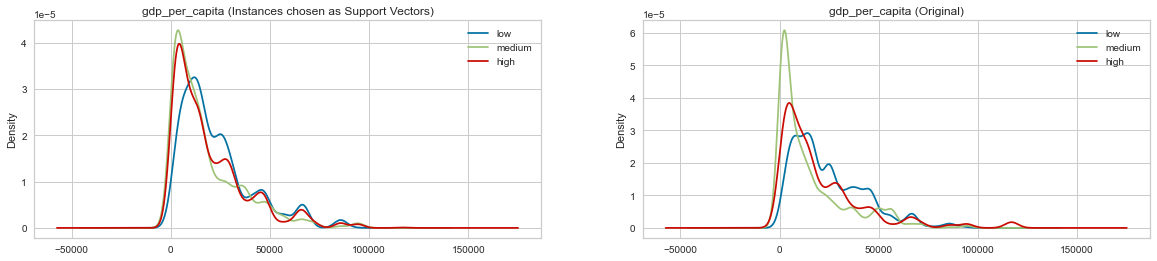

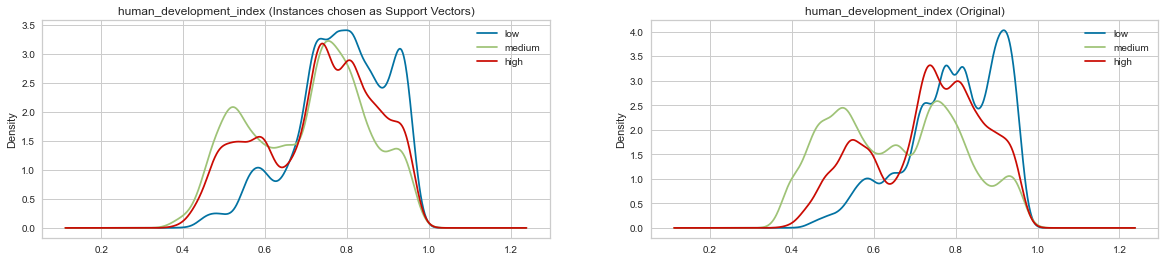

In [13]:
%%time
# SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model
svm_clf = SVC(C=0.5, kernel='rbf', decision_function_shape='ovo', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled_cat, y_train_cat)  # train object

y_hat_cat = svm_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )
print(conf)
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

# make a dataframe of the training data
df_tested_on = cat_df.iloc[train_indices].copy() # saved from above, the indices chosen for training
# get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['new_deaths_range'] = y_cat[svm_clf.support_] # add back in the 'new_deaths_range' Column to the pandas dataframe
cat_df['new_deaths_range'] = y_cat # also add it back in for the original data
df_support.info()

# statistics of the attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['new_deaths_range'])
df_grouped = cat_df.groupby(['new_deaths_range'])

# plot KDE of Different variables
vars_to_plot = ['stringency_index','population','gdp_per_capita','human_development_index']

for v in vars_to_plot:
    plt.figure(figsize=(20,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Original)')

### Naive - Bayes

In [9]:
%%time
#### Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Trying with default parameter
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_scaled_cat, y_train_cat)

y_hat_cat = gnb_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )

accuracy: 0.4487862640615749
CPU times: user 78.9 ms, sys: 8.3 ms, total: 87.2 ms
Wall time: 92.4 ms


In [10]:
%%time
# Trying different values for var_smoothing
# TODO: IMPLEMENT GRID SEARCH
gnb_clf = GaussianNB(var_smoothing=1)
gnb_clf.fit(X_train_scaled_cat, y_train_cat)

y_hat_cat = gnb_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )

accuracy: 0.5328596802841918
CPU times: user 72.1 ms, sys: 3.68 ms, total: 75.7 ms
Wall time: 80.2 ms


In [11]:
%%time
# Trying different values for var_smoothing
gnb_clf = GaussianNB(var_smoothing=10)
gnb_clf.fit(X_train_scaled_cat, y_train_cat)

y_hat_cat = gnb_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )

accuracy: 0.5189461219656601
CPU times: user 72.6 ms, sys: 3.66 ms, total: 76.2 ms
Wall time: 77.8 ms


In [12]:
%%time
# Trying different values for var_smoothing
gnb_clf = GaussianNB(var_smoothing=5)
gnb_clf.fit(X_train_scaled_cat, y_train_cat)

y_hat_cat = gnb_clf.predict(X_test_scaled_cat) # get test set predictions

acc_cat = mt.accuracy_score(y_test_cat,y_hat_cat)
conf = mt.confusion_matrix(y_test_cat,y_hat_cat, labels = ["high","medium","low"])
print('accuracy:', acc_cat )

accuracy: 0.5272350503256364
CPU times: user 72.8 ms, sys: 4.05 ms, total: 76.8 ms
Wall time: 76.3 ms


### kNN

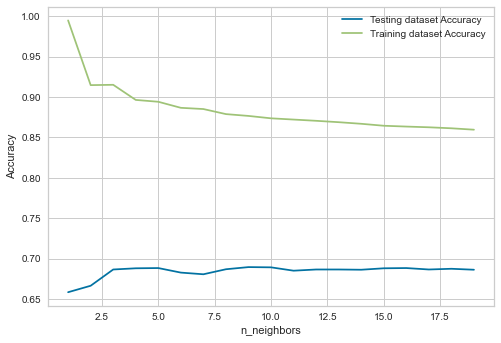

CPU times: user 44.3 s, sys: 1.12 s, total: 45.4 s
Wall time: 47.7 s


In [29]:
%%time
###############kNN##############
neighbors = np.arange(1,20)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled_cat, y_train_cat)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train_scaled_cat, y_train_cat)
    test_accuracy[i] = knn.score(X_test_scaled_cat, y_test_cat)
    #print(i,test_accuracy[i])
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()


In [30]:
%%time
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled_cat, y_train_cat)
print('The results are',knn.predict(X_test_scaled_cat))
print('The accuracy is',knn.score(X_test_scaled_cat, y_test_cat))




The results are ['low' 'low' 'high' ... 'high' 'medium' 'medium']
The accuracy is 0.6891651865008881
CPU times: user 850 ms, sys: 24.6 ms, total: 875 ms
Wall time: 919 ms


### Linear Regression

In [44]:
%%time
## Fit the scaled training data to the Linear Regressor and score with R squared

lr_model = LinearRegression().fit(X_train_scaled_reg, y_train_reg)
print('The accuracy of the model is\n',lr_model.score(X_train_scaled_reg, y_train_reg))
print('\n')
## calculate coefficents
print('The linear regression model coefficients are\n',lr_model.coef_)
print('\n')
## calculate intercept
print('The linear regression model intercept is\n',lr_model.intercept_)
print('\n')
##predict new deaths with test values
prediction_lr = lr_model.predict(X_test_scaled_reg)
print('The prediction values are\n',prediction_lr)
print('\n')
## Calculate the RMSE & print      
RMSE_lr = mean_squared_error(prediction_lr, y_test_reg, squared=False)
print('The RMSE is\n',RMSE_lr)

The accuracy of the model is
 0.751806318762606


The linear regression model coefficients are
 [  9.74284487 155.35336676  12.36955594 514.59287848 -52.77958326
  36.82191629 -27.63824879 -11.22443193  10.70582598 -18.55652274
 -14.71380087 -12.60545205  45.0537827 ]


The linear regression model intercept is
 165.28270534222014


The prediction values are
 [ -53.35164346  -57.43586438 4424.33434588 ...  -37.05337059   72.9234811
   50.88897032]


The RMSE is
 469.42196871204214
CPU times: user 21.3 ms, sys: 5.72 ms, total: 27 ms
Wall time: 20.2 ms


### Theil–Sen Regression

In [49]:
%%time
## Fit the scaled training data to the Thiel-Sen Regressor and score with R squared

ts_model = TheilSenRegressor(random_state=0).fit(X_train_scaled_reg, y_train_reg)
print('The Theil–Sen regression model accuracy is',ts_model.score(X_test_scaled_reg, y_test_reg))
print('\n')
      
 ## print the calculated coefficients for the attributes 
print('The Theil–Sen regression model coefficients are',ts_model.coef_)
print('\n')
 ## calculate intercept
print('The Theil–Sen regression model intercept is',ts_model.intercept_)
print('\n')
 ## Predict the new_deaths with the test values
prediction_ts = ts_model.predict(X_test_scaled_reg)

## Calculate the RMSE & print     
  
RMSE_ts = mean_squared_error(prediction_ts, y_test_reg, squared=False)

print('The model RMSE is',RMSE_ts) 

The Theil–Sen regression model accuracy is 0.48813425768982144


The Theil–Sen regression model coefficients are [-1.56630142e+00  3.22007294e+02  4.40213567e+00  3.44679649e+02
 -6.30031145e-01  1.63634590e+00 -1.06597120e+01 -3.10778397e+00
  2.93558518e+00 -1.44848868e-01  6.44236525e+00 -6.85004600e+00
  1.29562143e+01]


The Theil–Sen regression model intercept is 143.0387731005886


The model RMSE is 475.6489230481337
CPU times: user 8.67 s, sys: 1.63 s, total: 10.3 s
Wall time: 11.3 s


### RANSAC Regression

In [52]:
%%time
## Fit the scaled training data to the RANSAC Regressor
rs_model = RANSACRegressor(random_state=0).fit(X_train_scaled_reg, y_train_reg)
print('The accuracy of the RANSAC regression model is',rs_model.score(X_train_scaled_reg, y_train_reg))

 ## Predict the new_deaths with the test values
prediction_rs = rs_model.predict(X_test_scaled_reg)

 ## Calculate the RMSE & print     
  
RMSE_rs = mean_squared_error(prediction_rs, y_test_reg, squared=False)

print('The RMSE of the RANSAC regression model is',RMSE_rs)   

The accuracy of the RANSAC regression model is 0.33494532002782584
The RMSE of the RANSAC regression model is 554.9943487118157
CPU times: user 364 ms, sys: 173 ms, total: 537 ms
Wall time: 215 ms


### Random Forest

In [27]:
%%time
#RandomForestRegression

# Train the model on training data
modelRF = RandomForestRegressor()
modelRF.fit(X_train_scaled_reg, y_train_reg);
prediction_RF = modelRF.predict(X_test_scaled_reg)
#Evaluating the random forest regressor model algorithm using the error metrics
print('Mean Absolute Error:', mt.mean_absolute_error(y_test_reg, prediction_RF))  
print('Mean Squared Error:', mt.mean_squared_error(y_test_reg, prediction_RF))  
print('Root Mean Squared Error:', np.sqrt(mt.mean_squared_error(y_test_reg, prediction_RF)))





Mean Absolute Error: 50.79210255317041
Mean Squared Error: 52022.954633661044
Root Mean Squared Error: 228.08541083037522
CPU times: user 21.5 s, sys: 643 ms, total: 22.1 s
Wall time: 22.8 s


In [28]:
%%time
# create regressor object
RFregressor = RandomForestRegressor(n_estimators = 50)
# fit the regressor with x and y data
RFregressor.fit(X_train_scaled_reg,y_train_reg)
prediction_RF = RFregressor.predict(X_test_scaled_reg)
#Evaluating the random forest regressor model algorithm using the error metrics
print('Mean Absolute Error:', mt.mean_absolute_error(y_test_reg, prediction_RF))  
print('Mean Squared Error:', mt.mean_squared_error(y_test_reg, prediction_RF))  
print('Root Mean Squared Error:', np.sqrt(mt.mean_squared_error(y_test_reg, prediction_RF)))

Mean Absolute Error: 51.72903540785506
Mean Squared Error: 51955.31600030488
Root Mean Squared Error: 227.9370878121963
CPU times: user 10.4 s, sys: 238 ms, total: 10.7 s
Wall time: 11 s


 ## Modeling and Evaluation 4 - EVERY

> **Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.**

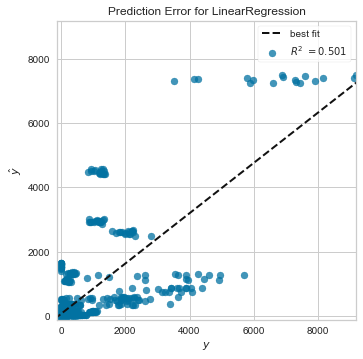

In [55]:
# Yellow Brick visualizer for Prediction Error for Linear Regression

lr_visualizer = PredictionError(lr_model, identity=False)

lr_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
lr_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
lr_visualizer.show();                 # Finalize and render the figure


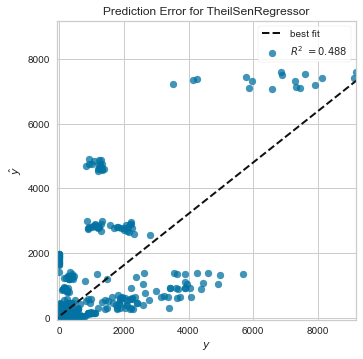

In [56]:
# Yellow Brick visualizer for Prediction Error for Thiel-Sen Regression

ts_visualizer = PredictionError(ts_model, identity=False)

ts_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
ts_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
ts_visualizer.show();                 # Finalize and render the figure

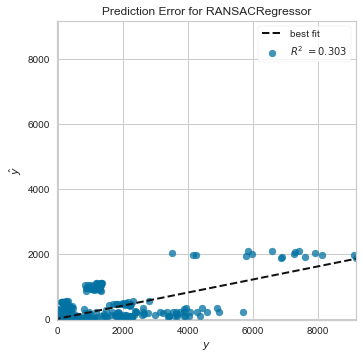

In [57]:
# Yellow Brick visualizer for Prediction Error for RANSAC Regression

rs_visualizer = PredictionError(rs_model, identity=False)

rs_visualizer.fit(X_train_scaled_reg, y_train_reg)  # Fit the training data to the visualizer
rs_visualizer.score(X_test_scaled_reg, y_test_reg)  # Evaluate the model on the test data
rs_visualizer.show();                 # Finalize and render the figure

 ## Modeling and Evaluation 5 - Sadik

> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

 ## Modeling and Evaluation 6 - Dawn

> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

 ## Deployment - Zach

> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 


> How would you measure the model's value if it was used by these parties? 

> How would your deploy your model for interested parties? 

> What other data should be collected? 

> How often would the model need to be updated, etc.? 

 ## Exceptional Work - Linear Regression, Yellow Brick

> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?